In [2]:
import os, codecs
import pandas as pd
import numpy as np

%pylab inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
# !ls ../input/ -l

## 读取数据

In [4]:
PATH = 'C://Users/win10/Desktop/code/DCIC2021/input_data/'

def bike_fence_format(s):
    s = s.replace('[', '').replace(']', '').split(',')
    s = np.array(s).astype(float).reshape(5, -1)
    return s


# 共享单车停车点位（电子围栏）数据
bike_fence = pd.read_csv(PATH + 'gxdc_tcd.csv')
bike_fence['FENCE_LOC'] = bike_fence['FENCE_LOC'].apply(bike_fence_format)

# 共享单车订单数据
bike_order = pd.read_csv(PATH + 'gxdc_dd.csv')
bike_order = bike_order.sort_values(['BICYCLE_ID', 'UPDATE_TIME'])

In [5]:
import geohash
bike_order['geohash'] = bike_order.apply(lambda x: 
                        geohash.encode(x['LATITUDE'], x['LONGITUDE'], precision=9), axis=1)

In [6]:
from geopy.distance import geodesic

# 得出停车点 LATITUDE 范围
bike_fence['MIN_LATITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 1]))
bike_fence['MAX_LATITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 1]))

# 得到停车点 LONGITUDE 范围
bike_fence['MIN_LONGITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 0]))
bike_fence['MAX_LONGITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 0]))

from geopy.distance import geodesic
# 根据停车点 范围 计算具体的面积
bike_fence['FENCE_AREA'] = bike_fence.apply(lambda x: geodesic(
    (x['MIN_LATITUDE'], x['MIN_LONGITUDE']), (x['MAX_LATITUDE'], x['MAX_LONGITUDE'])
).meters, axis=1)

# 根据停车点 计算中心经纬度
bike_fence['FENCE_CENTER'] = bike_fence['FENCE_LOC'].apply(
    lambda x: np.mean(x[:-1, ::-1], 0)
)

In [7]:
import geohash
bike_order['geohash'] = bike_order.apply(
    lambda x: geohash.encode(x['LATITUDE'], x['LONGITUDE'], precision=6), 
axis=1)

bike_fence['geohash'] = bike_fence['FENCE_CENTER'].apply(
    lambda x: geohash.encode(x[0], x[1], precision=6)
)

In [8]:
# bike_order
geohash.encode(24.521156, 118.140385, precision=8), \
geohash.encode(24.521156, 118.140325, precision=8)

('wsk52rgn', 'wsk52rgn')

In [13]:
bike_order.head()

,BICYCLE_ID,LATITUDE,LONGITUDE,LOCK_STATUS,UPDATE_TIME,geohash,DAY,HOUR,DAY_HOUR
34481,0000ff105fd5f9099b866bccd157dc50,24.521156,118.140385,0,2020-12-21 06:32:48,wsk52r,21,06,2106
41110,0000ff105fd5f9099b866bccd157dc50,24.496578,118.142543,1,2020-12-21 06:50:18,wsk527,21,06,2106
66106,0000ff105fd5f9099b866bccd157dc50,24.496582,118.142612,0,2020-12-21 08:23:32,wsk527,21,08,2108
65945,0000ff105fd5f9099b866bccd157dc50,24.481350,118.167496,1,2020-12-21 08:44:34,wsk52b,21,08,2108
3547,0000ff105fd5f9099b866bccd157dc50,24.509607,118.155216,0,2020-12-22 08:00:44,wsk52t,22,08,2208


In [17]:
bike_order.head

<bound method NDFrame.head of                               BICYCLE_ID   LATITUDE   LONGITUDE  LOCK_STATUS  \
34481   0000ff105fd5f9099b866bccd157dc50  24.521156  118.140385            0   
41110   0000ff105fd5f9099b866bccd157dc50  24.496578  118.142543            1   
66106   0000ff105fd5f9099b866bccd157dc50  24.496582  118.142612            0   
65945   0000ff105fd5f9099b866bccd157dc50  24.481350  118.167496            1   
3547    0000ff105fd5f9099b866bccd157dc50  24.509607  118.155216            0   
...                                  ...        ...         ...          ...   
539894  ffffa4a7c6cd6cda114fdb0e6f391038  24.465094  118.070651            0   
531173  ffffa4a7c6cd6cda114fdb0e6f391038  24.461162  118.067411            1   
417516  ffffa4a7c6cd6cda114fdb0e6f391038  24.484959  118.089377            0   
408135  ffffa4a7c6cd6cda114fdb0e6f391038  24.471156  118.105646            1   
433347  ffffa4a7c6cd6cda114fdb0e6f391038  24.471307  118.105738            0   

         

## 区域流量和潮汐统计

In [16]:
bike_order['UPDATE_TIME'] = pd.to_datetime(bike_order['UPDATE_TIME'])
bike_order['DAY'] = bike_order['UPDATE_TIME'].dt.day.astype(object)
bike_order['DAY'] = bike_order['DAY'].apply(str)

bike_order['HOUR'] = bike_order['UPDATE_TIME'].dt.hour.astype(object)
bike_order['HOUR'] = bike_order['HOUR'].apply(str)
bike_order['HOUR'] = bike_order['HOUR'].str.pad(width=2,side='left',fillchar='0')

bike_order['MINUTE'] = bike_order['UPDATE_TIME'].dt.minute.astype(object)
bike_order['MINUTE'] = bike_order['MINUTE'].apply(str)
bike_order['MINUTE'] = bike_order['MINUTE'].str.pad(width=2,side='left',fillchar='0')

bike_order['DAY_HOUR_MINUTE'] = bike_order['DAY'] + bike_order['HOUR']+bike_order['MINUTE']

## 按照经纬度聚合

In [22]:
bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY_HOUR'], aggfunc='count', fill_value=0
#                     columns=['DAY_HOUR_MINUTE'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY_HOUR'], aggfunc='count', fill_value=0
#                     columns=['DAY_HOUR_MINUTE'], aggfunc='count', fill_value=0
)

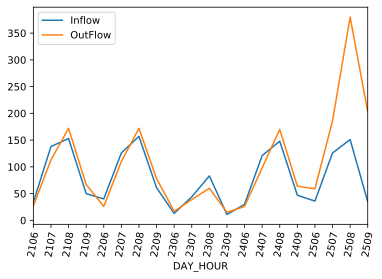

In [23]:
bike_inflow.loc['wsk52r'].plot()
bike_outflow.loc['wsk52r'].plot()
plt.xticks(list(range(bike_inflow.shape[1])), bike_inflow.columns, rotation=80)
plt.legend(['Inflow', 'OutFlow'])

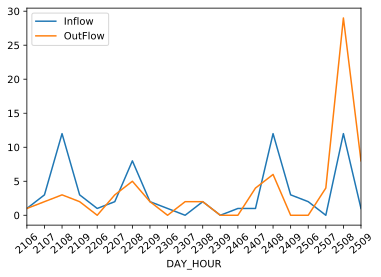

In [24]:
bike_inflow.loc['wsk596'].plot()
bike_outflow.loc['wsk596'].plot()
plt.xticks(list(range(bike_inflow.shape[1])), bike_inflow.columns, rotation=40)
plt.legend(['Inflow', 'OutFlow'])

In [26]:
bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

In [27]:
bike_remain = (bike_inflow - bike_outflow).fillna(0)

# 存在骑走的车数量 大于 进来的车数量
bike_remain[bike_remain < 0] = 0  

# 按照天求平均
bike_remain = bike_remain.sum(1)

In [28]:
# 总共有993条街
bike_fence['STREET'] = bike_fence['FENCE_ID'].apply(lambda x: x.split('_')[0])

# 留存车辆 / 街道停车位总面积，计算得到密度
bike_density = bike_fence.groupby(['STREET'])['geohash'].unique().apply(
    lambda hs: np.sum([bike_remain[x] for x in hs])
) / bike_fence.groupby(['STREET'])['FENCE_AREA'].sum()

# 按照密度倒序
bike_density = bike_density.sort_values(ascending=False).reset_index()

## 按照最近邻经纬度
如果使用Geohash来统计会存在一个问题，统计的方法会不准确，导致只能精确到街道信息。本节将使用经纬度距离匹配的方法来进行尝试，具体的思路为计算订单最近的停车点，进而计算具体的潮汐情况。

对于经纬度距离计算，可以直接使用sklearn中的NearestNeighbors，通过设置haversine距离可以很方便的完成最近停车点的计算。

In [29]:
from sklearn.neighbors import NearestNeighbors

# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
knn = NearestNeighbors(metric = "haversine", n_jobs=-1, algorithm='brute')
knn.fit(np.stack(bike_fence['FENCE_CENTER'].values))

NearestNeighbors(algorithm='brute', leaf_size=30, metric='haversine',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [31]:
# 需要11s左右
# dist, index = knn.kneighbors(bike_order[['LATITUDE','LONGITUDE']].values[:20000], n_neighbors=1)
dist, index = knn.kneighbors(bike_order[['LATITUDE','LONGITUDE']].values[:], n_neighbors=1)

In [32]:
bike_order['fence'] = bike_fence.iloc[index.flatten()]['FENCE_ID'].values

bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['fence'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['fence'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_remain = (bike_inflow - bike_outflow).fillna(0)
bike_remain[bike_remain < 0] = 0  
bike_remain = bike_remain.sum(1)

In [34]:
type(bike_remain)
bike_remain

pandas.core.series.Series

In [42]:
bike_density = bike_remain / bike_fence.set_index('FENCE_ID')['FENCE_AREA']
bike_density = bike_density.sort_values(ascending=False).reset_index()
bike_density = bike_density.fillna(0)

In [45]:
# bike_density = bike_density.cloumns = ['FENCE_ID','res']
bike_density = bike_density.rename(columns = {'index':'FENCE_ID',0:'res'}) 
bike_density

,FENCE_ID,res
0,观日路(望海路至会展路段 )_R_1,132.054140
1,象屿路0_R_1,100.175756
2,望海路0_R_2,79.024606
3,望海路0_R_1,65.889561
4,云顶北路0_R_45,52.407645
...,...,...
14066,鸿宾路_R_A17003,0.000000
14067,鹭江道0_L_A10014,0.000000
14068,龙山东路(龙山南路至盘龙路段 )_L_1,0.000000
14069,龙山北路_L_A03002,0.000000


In [37]:
bike_fence

,FENCE_ID,FENCE_LOC,MIN_LATITUDE,MAX_LATITUDE,MIN_LONGITUDE,MAX_LONGITUDE,FENCE_AREA,FENCE_CENTER,geohash,STREET
0,长乐路0_L_A17001,"[[118.103198, 24.527338], [118.103224, 24.5273...",24.527331,24.527373,118.103198,118.103236,6.039052,"[24.527352, 118.10321675]",ws7gx9,长乐路0
1,长乐路0_L_A17002,"[[118.103171, 24.527303], [118.103198, 24.5273...",24.527296,24.527338,118.103171,118.103209,6.039053,"[24.527317000000004, 118.10319]",ws7gx9,长乐路0
2,长乐路0_L_A17003,"[[118.103231, 24.527386], [118.103257, 24.5274...",24.527378,24.527421,118.103231,118.103270,6.188997,"[24.527399499999998, 118.1032505]",ws7gx9,长乐路0
3,长乐路0_L_A17004,"[[118.103257, 24.527421], [118.103282, 24.5274...",24.527413,24.527455,118.103257,118.103295,6.039051,"[24.527434, 118.10327600000001]",ws7gx9,长乐路0
4,长乐路0_L_A17005,"[[118.102948, 24.527003], [118.102979, 24.5270...",24.526995,24.527046,118.102948,118.102992,7.196632,"[24.5270205, 118.10297]",ws7gx3,长乐路0
...,...,...,...,...,...,...,...,...,...,...
14066,龙虎西二里_L_1,"[[118.1163951015, 24.4392429488], [118.1165434...",24.439229,24.439244,118.116395,118.116543,15.136775,"[24.4392363933, 118.11646929919999]",ws7gpc,龙虎西二里
14067,龙虎西二里_L_2,"[[118.1158786559, 24.4392522243], [118.1160686...",24.439240,24.439252,118.115879,118.116069,19.317500,"[24.43924593495, 118.11597365625]",ws7gpc,龙虎西二里
14068,龙虎西二里_L_3,"[[118.1155436336, 24.4392542666], [118.1156823...",24.439238,24.439254,118.115543,118.115682,14.201846,"[24.439245983600003, 118.11561291917499]",ws7gpc,龙虎西二里
14069,龙虎西二里_L_4,"[[118.1152026479, 24.4403235625], [118.1152037...",24.440323,24.440444,118.115203,118.115219,13.458712,"[24.440383766375, 118.115210615875]",ws7gpc,龙虎西二里


In [92]:
result_df = bike_density.merge(bike_fence, how='inner', on='FENCE_ID')
result_df

,FENCE_ID,res,FENCE_LOC,MIN_LATITUDE,MAX_LATITUDE,MIN_LONGITUDE,MAX_LONGITUDE,FENCE_AREA,FENCE_CENTER,geohash,STREET
0,观日路(望海路至会展路段 )_R_1,132.054140,"[[118.1811945889, 24.4881023165], [118.1811646...",24.488049,24.488109,118.181150,118.181195,8.027011,"[24.488079166250003, 118.1811723746]",wsk533,观日路(望海路至会展路段 )
1,象屿路0_R_1,100.175756,"[[118.088508795, 24.5137777608], [118.08849974...",24.513743,24.513782,118.088482,118.088509,5.061105,"[24.513762239325, 118.08849559525]",ws7grn,象屿路0
2,望海路0_R_2,79.024606,"[[118.179600502, 24.4916542622], [118.17958991...",24.491642,24.491677,118.179558,118.179601,5.732392,"[24.49165950575, 118.17957954625]",wsk534,望海路0
3,望海路0_R_1,65.889561,"[[118.181675856, 24.4898229298], [118.18159669...",24.489810,24.489835,118.181594,118.181676,8.741901,"[24.489822827774997, 118.18163499575]",wsk536,望海路0
4,云顶北路0_R_45,52.407645,"[[118.146595443, 24.5377544107], [118.14657921...",24.537749,24.537806,118.146558,118.146595,7.403500,"[24.53777771855, 118.14657666899998]",wsk586,云顶北路0
...,...,...,...,...,...,...,...,...,...,...,...
14066,鸿宾路_R_A17003,0.000000,"[[118.09927, 24.517886], [118.099232, 24.51789...",24.517886,24.517909,118.099232,118.099274,4.960484,"[24.5178975, 118.099253]",ws7grr,鸿宾路
14067,鹭江道0_L_A10014,0.000000,"[[118.074856, 24.450794], [118.074827, 24.4508...",24.450794,24.450858,118.074827,118.074870,8.322398,"[24.450826, 118.0748485]",ws7gng,鹭江道0
14068,龙山东路(龙山南路至盘龙路段 )_L_1,0.000000,"[[118.1373795084, 24.4831415373], [118.1373746...",24.483142,24.483219,118.137375,118.137395,8.829581,"[24.4831802475, 118.1373850463]",wsk523,龙山东路(龙山南路至盘龙路段 )
14069,龙山北路_L_A03002,0.000000,"[[118.136387, 24.491905], [118.136463, 24.4918...",24.491857,24.491905,118.136380,118.136463,9.952189,"[24.491881, 118.13642150000001]",wsk526,龙山北路


In [93]:
street_res = result_df.groupby(['STREET'])['res'].sum().reset_index()
# street_res
street_res = street_res.rename(columns = {'STREET':'STREET','res':'sterrt_res'}) 


In [94]:
street_res = street_res.sort_values(by=['sterrt_res'],ascending=False)

In [95]:
street_res = street_res.iloc[:40,:].reset_index()
street_res.head()

,index,STREET,sterrt_res
0,623,湖滨南路0,260.299781
1,303,安岭路,247.690839
2,38,云顶中路0,221.948523
3,60,仙岳路0,214.149917
4,446,望海路0,191.804029


In [96]:
street_res['BELONG_AREA'] = street_res['STREET']
street_res['FENCE_TYPE'] = '1'
street_res

,index,STREET,sterrt_res,BELONG_AREA,FENCE_TYPE
0,623,湖滨南路0,260.299781,湖滨南路0,1
1,303,安岭路,247.690839,安岭路,1
2,38,云顶中路0,221.948523,云顶中路0,1
3,60,仙岳路0,214.149917,仙岳路0,1
4,446,望海路0,191.804029,望海路0,1
5,947,高崎南五路0,183.360596,高崎南五路0,1
6,40,云顶北路0,175.559207,云顶北路0,1
7,199,厦禾路0,174.421642,厦禾路0,1
8,608,湖滨北路0,170.252151,湖滨北路0,1
9,965,鹭江道0,163.438601,鹭江道0,1


In [97]:
result_df = result_df.merge(street_res, how='left', on='STREET')

In [98]:
result_df

,FENCE_ID,res,FENCE_LOC,MIN_LATITUDE,MAX_LATITUDE,MIN_LONGITUDE,MAX_LONGITUDE,FENCE_AREA,FENCE_CENTER,geohash,STREET,index,sterrt_res,BELONG_AREA,FENCE_TYPE
0,观日路(望海路至会展路段 )_R_1,132.054140,"[[118.1811945889, 24.4881023165], [118.1811646...",24.488049,24.488109,118.181150,118.181195,8.027011,"[24.488079166250003, 118.1811723746]",wsk533,观日路(望海路至会展路段 ),828.0,132.054140,观日路(望海路至会展路段 ),1
1,象屿路0_R_1,100.175756,"[[118.088508795, 24.5137777608], [118.08849974...",24.513743,24.513782,118.088482,118.088509,5.061105,"[24.513762239325, 118.08849559525]",ws7grn,象屿路0,845.0,126.179488,象屿路0,1
2,望海路0_R_2,79.024606,"[[118.179600502, 24.4916542622], [118.17958991...",24.491642,24.491677,118.179558,118.179601,5.732392,"[24.49165950575, 118.17957954625]",wsk534,望海路0,446.0,191.804029,望海路0,1
3,望海路0_R_1,65.889561,"[[118.181675856, 24.4898229298], [118.18159669...",24.489810,24.489835,118.181594,118.181676,8.741901,"[24.489822827774997, 118.18163499575]",wsk536,望海路0,446.0,191.804029,望海路0,1
4,云顶北路0_R_45,52.407645,"[[118.146595443, 24.5377544107], [118.14657921...",24.537749,24.537806,118.146558,118.146595,7.403500,"[24.53777771855, 118.14657666899998]",wsk586,云顶北路0,40.0,175.559207,云顶北路0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14066,鸿宾路_R_A17003,0.000000,"[[118.09927, 24.517886], [118.099232, 24.51789...",24.517886,24.517909,118.099232,118.099274,4.960484,"[24.5178975, 118.099253]",ws7grr,鸿宾路,NaN,NaN,NaN,NaN
14067,鹭江道0_L_A10014,0.000000,"[[118.074856, 24.450794], [118.074827, 24.4508...",24.450794,24.450858,118.074827,118.074870,8.322398,"[24.450826, 118.0748485]",ws7gng,鹭江道0,965.0,163.438601,鹭江道0,1
14068,龙山东路(龙山南路至盘龙路段 )_L_1,0.000000,"[[118.1373795084, 24.4831415373], [118.1373746...",24.483142,24.483219,118.137375,118.137395,8.829581,"[24.4831802475, 118.1373850463]",wsk523,龙山东路(龙山南路至盘龙路段 ),NaN,NaN,NaN,NaN
14069,龙山北路_L_A03002,0.000000,"[[118.136387, 24.491905], [118.136463, 24.4918...",24.491857,24.491905,118.136380,118.136463,9.952189,"[24.491881, 118.13642150000001]",wsk526,龙山北路,NaN,NaN,NaN,NaN


In [109]:
result_final = result_df.loc[:,['FENCE_ID']]
result_final['FENCE_TYPE'] = result_df['FENCE_TYPE'].fillna('0')
result_final['BELONG_AREA'] = result_df.loc[:,['BELONG_AREA']]


In [110]:
result_final

,FENCE_ID,FENCE_TYPE,BELONG_AREA
0,观日路(望海路至会展路段 )_R_1,1,观日路(望海路至会展路段 )
1,象屿路0_R_1,1,象屿路0
2,望海路0_R_2,1,望海路0
3,望海路0_R_1,1,望海路0
4,云顶北路0_R_45,1,云顶北路0
...,...,...,...
14066,鸿宾路_R_A17003,0,NaN
14067,鹭江道0_L_A10014,1,鹭江道0
14068,龙山东路(龙山南路至盘龙路段 )_L_1,0,NaN
14069,龙山北路_L_A03002,0,NaN


In [111]:
result_final.to_csv('C://Users/win10/Desktop/code/DCIC2021/res/result.txt')